# **TP08 - KMEAN Y EM**

In [110]:
import os
import requests
import zipfile

import librosa
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt

from IPython.display import Audio

from scipy.signal import stft

from sklearn.mixture import GaussianMixture

import pandas as pd


In [111]:


# URL del archivo ZIP en GitHub (modificá esto con el link real)
url = 'https://raw.githubusercontent.com/mvera1412/TA136-TB056-TB057-8625/refs/heads/main/data/instrumentos.zip'
zip_path = 'instrumentos.zip'
extract_dir = 'instrumentos'

# Descargar el archivo ZIP
response = requests.get(url)
with open(zip_path, 'wb') as f:
    f.write(response.content)

# Extraer el contenido
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Archivo descargado y extraído en: {extract_dir}')

Archivo descargado y extraído en: instrumentos


In [112]:
# Ruta a la carpeta con los audios mezclados
base_dir = 'instrumentos'

# Listar archivos de audio
archivos = sorted([f for f in os.listdir(base_dir) if f.endswith('.mp3')])

# Agrupar por instrumento (asumiendo que el nombre es tipo 'piano_1.wav')
instrumentos_dict = defaultdict(list)
for archivo in archivos:
    nombre = archivo.split('_')[0]  # por ejemplo, 'piano'
    instrumentos_dict[nombre].append(archivo)

# Diccionarios para datos
X_train, y_train = [], []
X_test, y_test = [], []

# Parámetros
sr = 22050
duration = 2

# Mapeo instrumento → número de clase
instrumento_a_idx = {inst: idx for idx, inst in enumerate(sorted(instrumentos_dict.keys()))}

for instrumento, lista_archivos in instrumentos_dict.items():
    lista_archivos.sort()  # asegurarse que estén ordenados
    idx = instrumento_a_idx[instrumento]
    
    for i, archivo in enumerate(lista_archivos):
        ruta = os.path.join(base_dir, archivo)
        audio, _ = librosa.load(ruta, sr=sr, duration=duration)

        # Padding o recorte
        if len(audio) < sr * duration:
            audio = np.pad(audio, (0, sr * duration - len(audio)))
        else:
            audio = audio[:sr * duration]
        
        if i == len(lista_archivos) - 1:
            X_test.append(audio)
            y_test.append(idx)
        else:
            X_train.append(audio)
            y_train.append(idx)

print(f'Total entrenamiento: {len(X_train)} muestras')
print(f'Total testeo: {len(X_test)} muestras')
print('Instrumentos:', instrumento_a_idx)


Total entrenamiento: 20 muestras
Total testeo: 5 muestras
Instrumentos: {'clarinet': 0, 'guitar': 1, 'saxophone': 2, 'trumpet': 3, 'violin': 4}


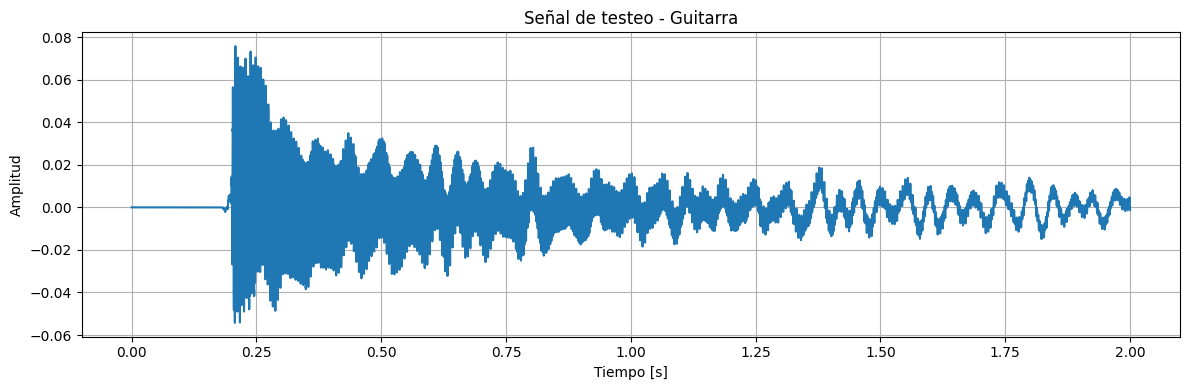

In [113]:
# Asegurarse de tener esto definido de antes
# instrumento_a_idx = {'flauta': 0, 'guitarra': 1, ...}
# X_test: lista de señales
# y_test: lista de etiquetas
# sr: sample rate (ej. 22050)

# Paso 1: índice correspondiente a 'guitarra'
idx_guitarra = instrumento_a_idx.get('guitar')
if idx_guitarra is None:
    print("❌ No se encontró el instrumento 'guitarra'")
else:
    # Paso 2: buscar la señal de testeo que corresponda a guitarra
    for i in range(len(y_test)):
        if y_test[i] == idx_guitarra:
            señal = X_test[i]
            break
    else:
        print("❌ No hay señal de testeo para 'guitarra'")
        señal = None

    if señal is not None:
        # Paso 3: generar eje de tiempo
        duracion = len(señal) / sr
        tiempo = np.linspace(0, duracion, len(señal))

        # Paso 4: graficar
        plt.figure(figsize=(12, 4))
        plt.plot(tiempo, señal)
        plt.title('Señal de testeo - Guitarra')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Amplitud')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


In [114]:
# Obtener índice numérico de 'guitarra'
idx_guitarra = instrumento_a_idx['guitar']

# Obtener índice en y_test (asumiendo que hay uno solo)
i = y_test.index(idx_guitarra)

# Obtener la señal
señal_guitarra = X_test[i]

# Reproducirla
Audio(data=señal_guitarra, rate=sr)


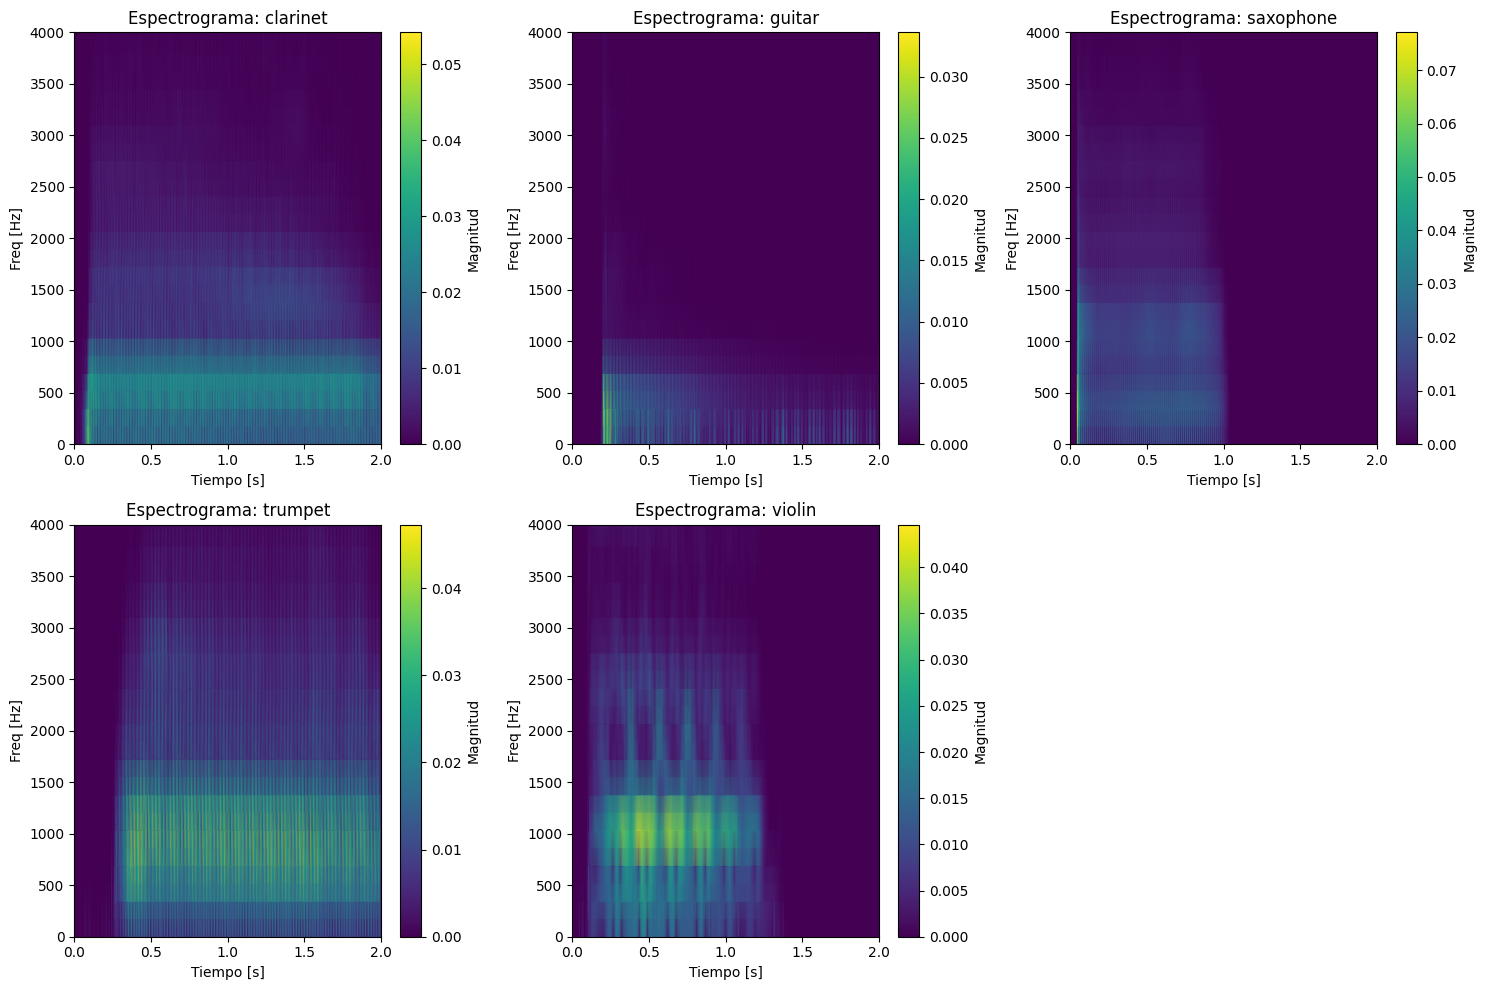

In [115]:
# Invertimos el diccionario para pasar de idx a nombre instrumento
idx_a_instrumento = {v: k for k, v in instrumento_a_idx.items()}

n_fft = 64
noverlap = n_fft // 2
window = 'hamming'

num_señales = len(X_test)
cols = 3
rows = (num_señales + cols - 1) // cols  # ceil para filas

plt.figure(figsize=(15, 5 * rows))

for i, señal in enumerate(X_test):
    f, t, Zxx = stft(señal, fs=sr, window=window, nperseg=n_fft, noverlap=noverlap)
    espectrograma = np.abs(Zxx)

    plt.subplot(rows, cols, i + 1)
    plt.pcolormesh(t, f, espectrograma, shading='gouraud')
    plt.title(f"Espectrograma: {idx_a_instrumento[y_test[i]]}")
    plt.ylabel('Freq [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.ylim(0,4000)
    plt.colorbar(label='Magnitud')

plt.tight_layout()
plt.show()

In [116]:
class Kmeans:
    def __init__(self, n_clusters=6, max_iter=100, tol=1e-4, random_state=None):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        
        self.centroids = None
    
    def fit(self, X):
        np.random.seed(self.random_state)
        
        # Inicializar centroides aleatoriamente desde X
        indices = np.random.choice(len(X), self.n_clusters, replace=False)
        self.centroids = X[indices]
        
        for it in range(self.max_iter):
            # Asignar cada punto a cluster más cercano
            distancias = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
            labels = np.argmin(distancias, axis=1)
            
            # Actualizar centroides
            nuevos_centroides = np.array([X[labels == k].mean(axis=0) if np.any(labels==k) else self.centroids[k] 
                                          for k in range(self.n_clusters)])
            
            # Chequear convergencia
            dif = np.linalg.norm(self.centroids - nuevos_centroides)
            self.centroids = nuevos_centroides
            if dif < self.tol:
                break
    
    def predict(self, X):
        distancias = np.linalg.norm(X[:, None] - self.centroids[None, :], axis=2)
        return np.argmin(distancias, axis=1)


kmeans_models = {}

for inst, idx in instrumento_a_idx.items():
    print(f"\nEntrenando KMeans para instrumento: {inst} (clase {idx})")

    # Tomar solo los samples de este instrumento
    X_inst = np.array([x for x, y in zip(X_train, y_train) if y == idx])
    print(f" - Cantidad de muestras: {len(X_inst)}")
    print(f" - Dimensión de cada muestra: {X_inst.shape[1]}")

    # Suponiendo que X_inst tiene forma (N_samples, feature_dim)
    model = Kmeans(n_clusters=4, max_iter=100, random_state=42)
    model.fit(X_inst)

    print(f" - Centroides finales shape: {model.centroids.shape}")
    print(f" - Centroides:\n{model.centroids}")

    kmeans_models[inst] = model





Entrenando KMeans para instrumento: clarinet (clase 0)
 - Cantidad de muestras: 4
 - Dimensión de cada muestra: 44100
 - Centroides finales shape: (4, 44100)
 - Centroides:
[[ 8.7311491e-11  1.1641532e-10  1.4551915e-10 ... -2.4288120e-02
  -1.4903992e-02 -5.0664232e-03]
 [-1.1641532e-10 -1.7462298e-10 -1.8917490e-10 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  2.9103830e-10  2.3283064e-10 ... -5.3830992e-02
  -3.7033923e-02 -1.6303943e-02]
 [-1.4551915e-10 -3.4924597e-10 -2.1827873e-10 ...  5.9381705e-03
   1.2556074e-02  1.9495446e-02]]

Entrenando KMeans para instrumento: guitar (clase 1)
 - Cantidad de muestras: 4
 - Dimensión de cada muestra: 44100
 - Centroides finales shape: (4, 44100)
 - Centroides:
[[-3.4106051e-12  4.8316906e-13  0.0000000e+00 ... -1.1317555e-02
  -1.0871004e-02 -1.1727971e-02]
 [ 1.0231815e-12 -2.2168933e-12 -2.2737368e-13 ...  5.2202754e-03
   5.7365815e-03  6.9135334e-03]
 [ 5.6274985e-12 -4.2064130e-12  7.6170181e-12 ... -1.17503

In [117]:
def extract_spec_frames(signals, sr, n_fft=512, hop_length=256, window='hamming'):
    """
    signals: lista de arrays de audio (cada uno 1D).
    devuelve: array de forma (total_frames, n_freq_bins)
    """
    all_frames = []
    for x in signals:
        # STFT
        f, t, Zxx = stft(x, fs=sr, window=window,
                         nperseg=n_fft, noverlap=n_fft-hop_length)
        S = np.abs(Zxx)                # (n_freq_bins, n_time_frames)
        S_db = 20 * np.log10(S + 1e-6) # opcional: a dB para estabilizar
        # Cada columna es un vector de características
        frames = S_db.T                # (n_time_frames, n_freq_bins)
        all_frames.append(frames)
    return np.vstack(all_frames)      # (sum n_time_frames, n_freq_bins)


kmeans_models_v2 = {}
sr = 22050
n_fft = 512
hop = n_fft // 2

for inst, idx in instrumento_a_idx.items():
    print(f"\n=== Instrumento: {inst} (clase {idx}) ===")
    # 1) Recolectar señales de entrenamiento
    signals = [x for x, y in zip(X_train, y_train) if y == idx]
    print(f"- Señales: {len(signals)} muestras")

    # 2) Extraer todos los frames del espectrograma
    X_frames = extract_spec_frames(signals, sr, n_fft=n_fft, hop_length=hop)
    print(f"- Frames totales: {X_frames.shape[0]} (cada uno de {X_frames.shape[1]} bins)")

    # 3) Entrenar KMeans sobre frames espectrales
    model = Kmeans(n_clusters=6, max_iter=100, random_state=42)
    model.fit(X_frames)

    print(f"- Centroides: {model.centroids.shape}  (6 centroides de {model.centroids.shape[1]} dimensiones)")
    kmeans_models_v2[inst] = model



=== Instrumento: clarinet (clase 0) ===
- Señales: 4 muestras
- Frames totales: 696 (cada uno de 257 bins)
- Centroides: (6, 257)  (6 centroides de 257 dimensiones)

=== Instrumento: guitar (clase 1) ===
- Señales: 4 muestras
- Frames totales: 696 (cada uno de 257 bins)
- Centroides: (6, 257)  (6 centroides de 257 dimensiones)

=== Instrumento: saxophone (clase 2) ===
- Señales: 4 muestras
- Frames totales: 696 (cada uno de 257 bins)
- Centroides: (6, 257)  (6 centroides de 257 dimensiones)

=== Instrumento: trumpet (clase 3) ===
- Señales: 4 muestras
- Frames totales: 696 (cada uno de 257 bins)
- Centroides: (6, 257)  (6 centroides de 257 dimensiones)

=== Instrumento: violin (clase 4) ===
- Señales: 4 muestras
- Frames totales: 696 (cada uno de 257 bins)
- Centroides: (6, 257)  (6 centroides de 257 dimensiones)


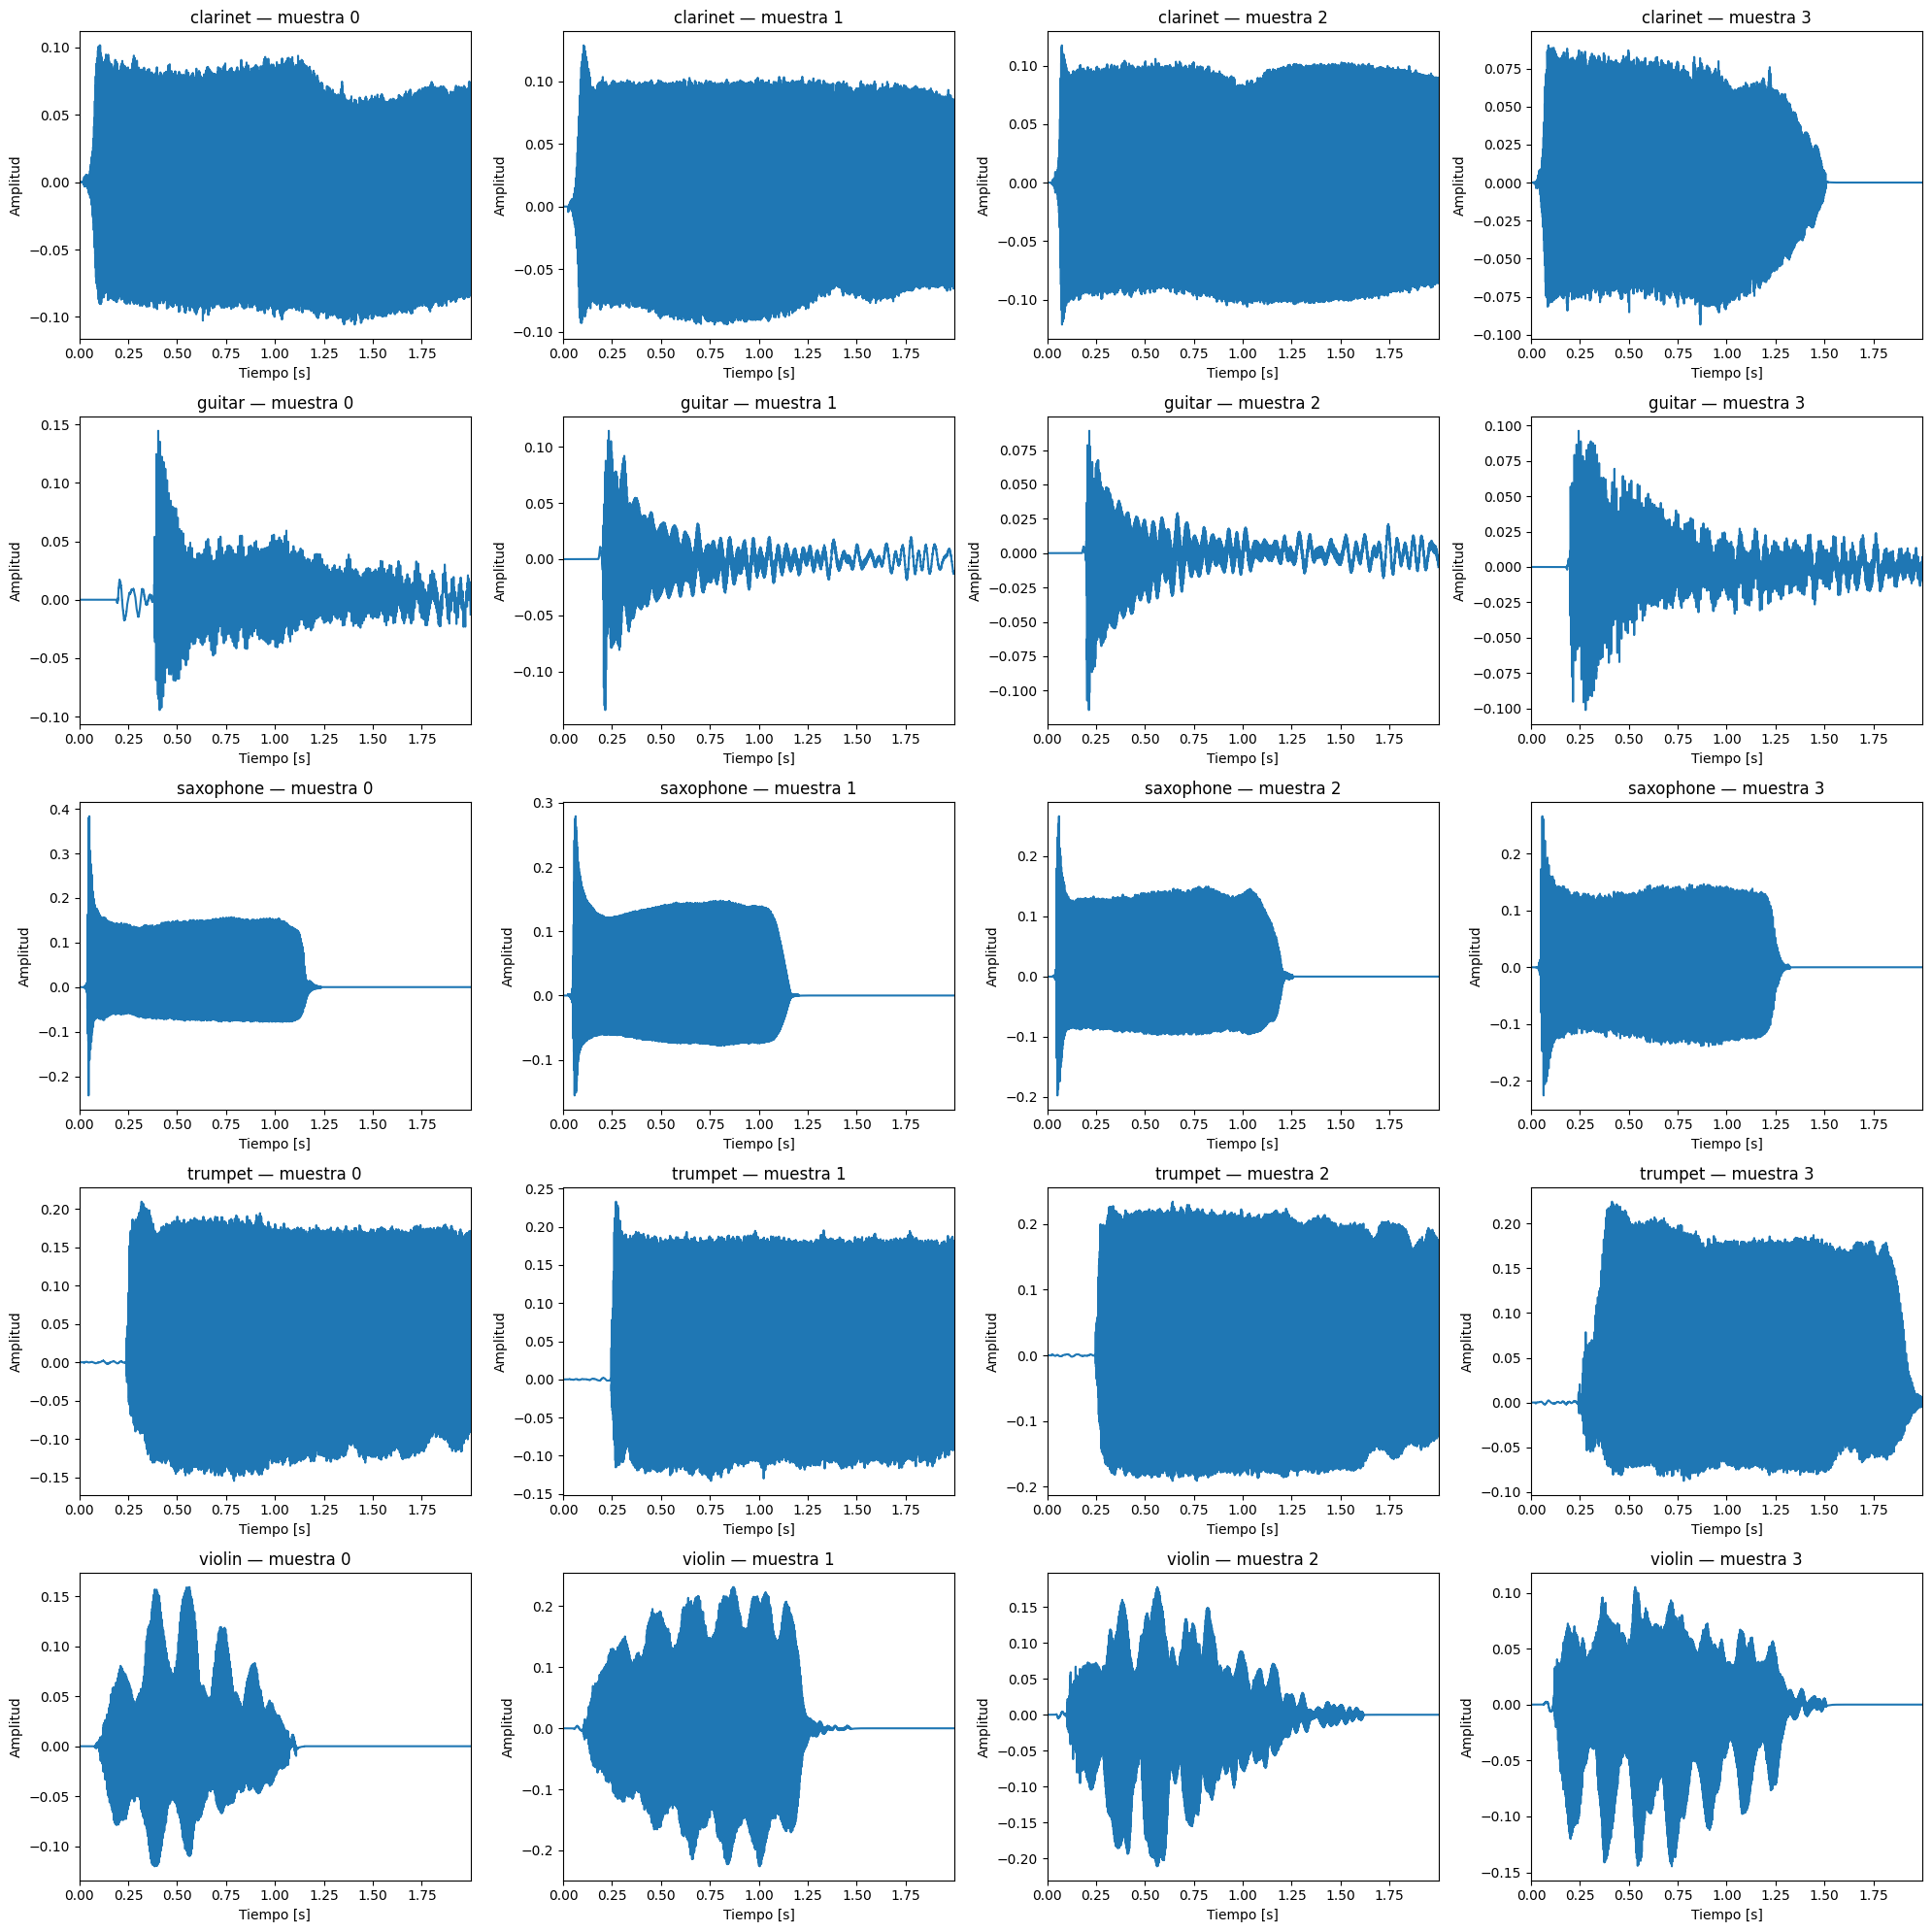

In [118]:
import numpy as np
import matplotlib.pyplot as plt

# Sample rate
sr = 22050

# Número de instrumentos / clases
instrumentos = sorted(instrumento_a_idx.keys())
n_inst = len(instrumentos)
n_muestras = 4  # según tu entrenamiento

# Creamos la figura con n_inst filas y 4 columnas
fig, axs = plt.subplots(nrows=n_inst, ncols=n_muestras, figsize=(20, 4 * n_inst), sharex=False, sharey=False)

for row, inst in enumerate(instrumentos):
    idx = instrumento_a_idx[inst]
    # Recolectamos las 4 señales de entrenamiento de este instrumento
    X_inst = [x for x, y in zip(X_train, y_train) if y == idx]
    
    for col in range(n_muestras):
        señal = X_inst[col]
        tiempo = np.arange(len(señal)) / sr
        ax = axs[row, col]
        ax.plot(tiempo, señal)
        ax.set_title(f"{inst} — muestra {col}")
        ax.set_xlabel("Tiempo [s]")
        ax.set_ylabel("Amplitud")
        ax.set_xlim(0, tiempo[-1])

plt.tight_layout()
plt.show()



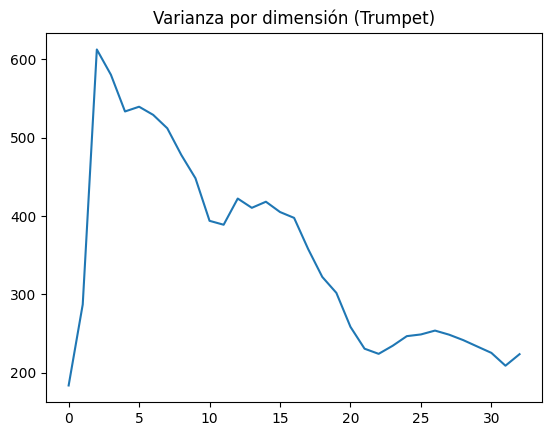

In [119]:
signals = [x for x, y in zip(X_train, y_train) if y == instrumento_a_idx['trumpet']]
X_frames = extract_spec_frames(signals, sr=22050, n_fft=64, hop_length=64//2)
plt.plot(np.var(X_frames, axis=0))
plt.title("Varianza por dimensión (Trumpet)")
plt.show()

In [120]:

from sklearn.mixture import GaussianMixture

gmm_models = {}

for inst, kmeans in kmeans_models.items():
    means_init = kmeans.centroids
    
    # Inicializar pesos uniformes
    weights_init = np.ones(kmeans.n_clusters) / kmeans.n_clusters
    
    # Inicializar varianzas diagonales con varianza global (o de cluster)
    # Por simplicidad usamos varianza global de todos los datos del instrumento
    X_inst = np.array([x for x, y in zip(X_train, y_train) if y == instrumento_a_idx[inst]])
    var_global = np.var(X_inst, axis=0)
    
    # precisions_init para covarianza diagonal = 1/var
    precisions_init = np.array([1 / (var_global + 1e-6) for _ in range(kmeans.n_clusters)])
    
    gmm = GaussianMixture(
        n_components=kmeans.n_clusters, covariance_type='diag',
        means_init=means_init,
        weights_init=weights_init,
        precisions_init=precisions_init,
        max_iter=100, random_state=42
    )
    
    gmm.fit(X_inst)
    gmm_models[inst] = gmm



In [121]:
# Asumimos que:
# - gmm_models es un dict: instrumento -> modelo GMM entrenado
# - y_test contiene índices (0 a 4) correspondientes a los instrumentos
# - X_test es la lista de features/test
# - instrumento_a_idx y idx_a_instrumento permiten traducir entre índices y nombres

# Si no lo tenés aún:
idx_a_instrumento = {v: k for k, v in instrumento_a_idx.items()}

# Inicializar matriz de log-verosimilitud (5x5)
n_clases = len(instrumento_a_idx)
log_likelihoods = np.zeros((n_clases, n_clases))

# Convertir a array por comodidad
X_test = np.array(X_test)
y_test = np.array(y_test)

# Para cada clase real i
for i in range(n_clases):
    clase_i_mask = (y_test == i)
    muestras_clase_i = X_test[clase_i_mask]

    # Para cada modelo j
    for j in range(n_clases):
        modelo_j = gmm_models[idx_a_instrumento[j]]
        ll = modelo_j.score_samples(muestras_clase_i)  # log-verosimilitudes de cada muestra
        log_likelihoods[i, j] = ll.mean()  # promedio para la tabla

# Mostrar como DataFrame
df_ll = pd.DataFrame(
    log_likelihoods,
    index=[f'Real: {idx_a_instrumento[i]}' for i in range(n_clases)],
    columns=[f'Modelo: {idx_a_instrumento[j]}' for j in range(n_clases)]
)

print(df_ll)

                 Modelo: clarinet  Modelo: guitar  Modelo: saxophone  \
Real: clarinet      -7.958387e+07   -5.383709e+07      -7.694375e+07   
Real: guitar        -3.200476e+07   -6.292383e+06      -2.935814e+07   
Real: saxophone     -5.479219e+07   -2.916813e+07      -5.326068e+07   
Real: trumpet       -9.755619e+07   -7.184210e+07      -9.487836e+07   
Real: violin        -6.235159e+07   -3.725482e+07      -6.021636e+07   

                 Modelo: trumpet  Modelo: violin  
Real: clarinet     -9.076759e+07   -6.789974e+07  
Real: guitar       -4.285912e+07   -2.031422e+07  
Real: saxophone    -6.609480e+07   -4.309794e+07  
Real: trumpet      -1.089178e+08   -8.579496e+07  
Real: violin       -7.385833e+07   -5.110071e+07  


In [122]:
instrumentos = list(kmeans_models.keys())  # mismo orden para filas y columnas
n_inst = len(instrumentos)

log_likelihood_matrix = np.zeros((n_inst, n_inst))

for i, inst_true in enumerate(instrumentos):
    # Obtener frames de la clase real i
    signals = [x for x, y in zip(X_train, y_train) if y == instrumento_a_idx[inst_true]]
    X_frames = extract_spec_frames(signals, sr=22050, n_fft=512, hop_length=256)
    
    for j, inst_model in enumerate(instrumentos):
        gmm = gmm_models_v2[inst_model]
        ll = gmm.score_samples(X_frames)  # log-verosimilitud por muestra
        log_likelihood_matrix[i, j] = ll.mean()  # promedio
    
# Convertir a DataFrame para visualización
df_ll = pd.DataFrame(log_likelihood_matrix, index=instrumentos, columns=instrumentos)
print("\nMatriz de log-verosimilitud promedio (filas=clase real, columnas=modelo GMM):\n")
print(df_ll.round(2))

KeyError: 'saxophone'